In [1]:
import torch as t
import gpytorch
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

In [2]:
rcParams["figure.facecolor"] = "white"

In [3]:
pth = "/home/alma/w-projects/spatential/data/mouse-kidney/raw"
adata = sc.read_visium(pth)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


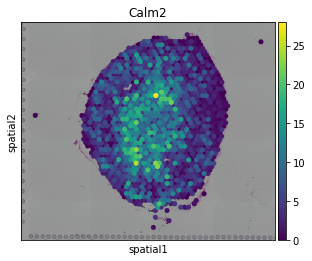

In [4]:
sc.pl.spatial(adata,color=["Calm2"],size  = 2)

In [5]:
train_y = adata.obs_vector("Calm2")
train_y = np.sqrt(np.array(train_y) + 3/8)
train_y = t.tensor(train_y.astype(np.float32))

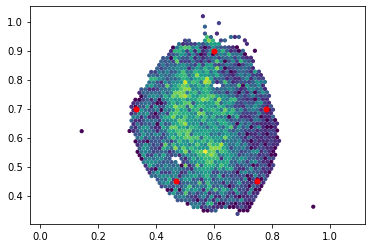

In [6]:
landmarks_x = np.array([7800,6000,3300,4700,7500]).reshape(-1,1) / 10000
landmarks_y = np.array([7000,9000,7000,4500,4500]).reshape(-1,1) / 10000
crd = adata.obsm["spatial"] / 10000
plt.scatter(crd[:,0],crd[:,1],s= 10,c = train_y)
plt.scatter(landmarks_x,landmarks_y,s = 25, c  ="red")
plt.axis("equal")
lmrk = np.hstack((landmarks_x,landmarks_y))

In [7]:
lcrd = np.zeros((adata.shape[0],lmrk.shape[0]))
for l in range(lmrk.shape[0]):
    for s in range(crd.shape[0]):
        lcrd[s,l] = ((crd[s,0] - lmrk[l,0])**2 + (crd[s,1] - lmrk[l,1])**2)**0.5 

In [8]:
train_x = t.tensor(lcrd.astype(np.float32)) 
train_x

tensor([[0.3697, 0.2533, 0.0872, 0.2867, 0.4397],
        [0.2065, 0.0940, 0.4087, 0.4911, 0.4411],
        [0.2058, 0.3779, 0.3782, 0.2118, 0.1140],
        ...,
        [0.3728, 0.5053, 0.3838, 0.1086, 0.1935],
        [0.2538, 0.4233, 0.3910, 0.1858, 0.1013],
        [0.3827, 0.2124, 0.1308, 0.3574, 0.4888]])

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


In [16]:
train_x.shape,train_y.shape

(torch.Size([1438, 5]), torch.Size([1438]))

In [11]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = t.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if (i+1) % 100 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

/home/alma/.local/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Iter 100/1000 - Loss: 1.127   lengthscale: 0.359   noise: 0.538
Iter 200/1000 - Loss: 1.118   lengthscale: 0.220   noise: 0.518
Iter 300/1000 - Loss: 1.098   lengthscale: 0.095   noise: 0.454
Iter 400/1000 - Loss: 1.095   lengthscale: 0.085   noise: 0.455


KeyboardInterrupt: 

In [13]:
output

MultivariateNormal(loc: torch.Size([1438]))

In [273]:
f_preds = model(train_x)
y_preds = likelihood(model(train_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix


In [ ]:
from scipy.spatial.distance import cdist
lmrk1_dmat = cdist(lmrk,lmrk)
lmrk2_dmat = cdist(lmrk2,lmrk2)
lmrk2_dmat[lmrk2_dmat==0] = 1
prp_mat = lmrk1_dmat / lmrk2_dmat
av_sf = np.sum(prp_mat,axis=1) / (prp_mat.shape[1] - 1)

In [370]:
center = np.array([6000,7000]) / 10000
r = 3000 / 10000

rs = np.linspace(0,r,50)
thetas =np.linspace(0,2*np.pi,300)

R,T = np.meshgrid(rs,thetas)
R = R.flatten()
T = T.flatten()
new_crd = np.zeros((R.shape[0],2))
new_crd[:,0] = center[0] + R*np.cos(T)
new_crd[:,1] = center[1] + R*np.sin(T)

lmrk2 = np.zeros((lmrk.shape[0],2))
lmrk2[:,0] = r * 0.95 * np.cos(np.linspace(0.2,(2*np.pi*0.8+0.2),5)) + center[0]
lmrk2[:,1] = r * 0.95 * np.sin(np.linspace(0.2,(2*np.pi*0.8+0.2),5)) + center[1]

dists = np.zeros((new_crd.shape[0],lmrk.shape[0]))
for l in range(lmrk.shape[0]):
    for s in range(new_crd.shape[0]):
        dists[s,l] = ((new_crd[s,0] - lmrk2[l,0])**2 + (new_crd[s,1] - lmrk2[l,1])**2)**0.5 
        dists[s,l] *= av_sf[l]

In [371]:
lmrk2

array([[0.87931897, 0.75662076],
       [0.63246477, 0.98314491],
       [0.34074536, 0.81837242],
       [0.40730705, 0.49001327],
       [0.74016385, 0.45184865]])

In [373]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with t.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = t.tensor(dists.astype(np.float32))
    observed_pred = likelihood(model(test_x))



In [303]:
observed_pred.mean.numpy()

array([1.9423913, 1.9423913, 1.9423913, ..., 1.9423913, 1.9423913,
       1.9423913], dtype=float32)

(0.10364000000000001, 0.98276, 0.302395, 1.052705)

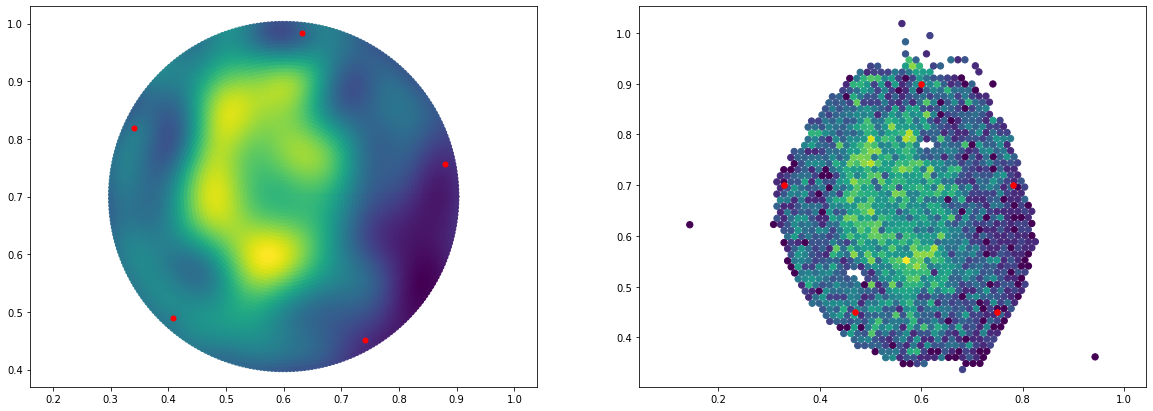

In [374]:
plt.figure(figsize = (20,7))
plt.subplot(121)

plt.scatter(new_crd[:,0],
            new_crd[:,1],
            s= 20,
            c = observed_pred.mean.numpy(),
           )
plt.scatter(lmrk2[:,0],lmrk2[:,1],s = 25, c  ="red")
plt.axis("equal")

plt.subplot(122)
plt.scatter(crd[:,0],crd[:,1],s= 40,c = train_y)
plt.scatter(landmarks_x,landmarks_y,s = 30, c  ="red")
plt.axis("equal")

In [398]:
def minfun(x0,ls,ds2,sf):
    loss = 0
    nl = ls.shape[0]
    for ii in range(nl):
        p1 = sum((x0[j] - ls[ii,j])**2 for j in range(2))
        p2 = ds2[ii]*sf[ii]
        loss += (p1-p2)**2
    return loss
        

In [417]:
from scipy.optimize import minimize

lcrd2 = lcrd**2
new_crd_opt = np.zeros(crd.shape)
for s in range(new_crd_opt.shape[0]):
    res = minimize(minfun,
                   x0 = new_crd_opt[s,:],
                   args = (lmrk2,
                           lcrd2[s,:],
                           av_sf**2),
                  method = "Nelder-Mead",
                  )
    new_crd_opt[s,:] = res["x"]

(0.10364000000000001, 0.98276, 0.302395, 1.052705)

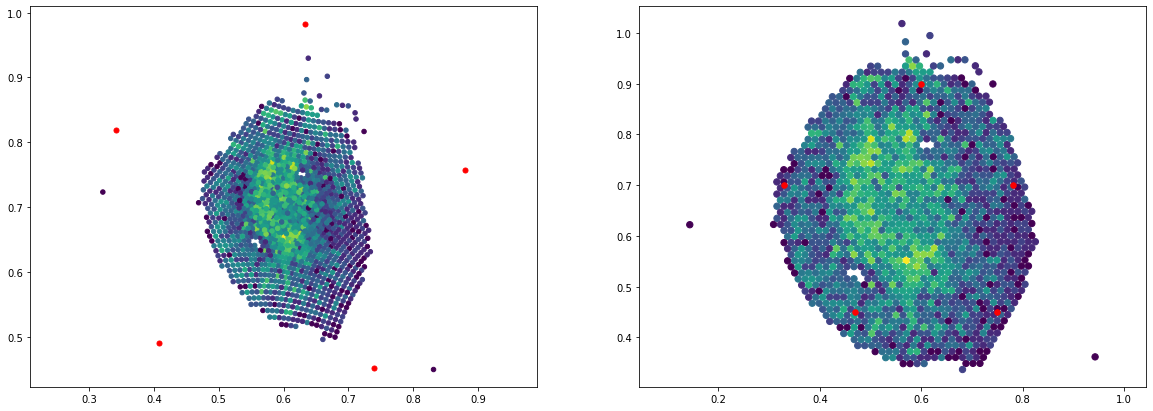

In [418]:
plt.figure(figsize = (20,7))
plt.subplot(121)

plt.scatter(new_crd_opt[:,0],
            new_crd_opt[:,1],
            s= 20,
            c = train_y,
           )
plt.scatter(lmrk2[:,0],lmrk2[:,1],s = 25, c  ="red")
plt.axis("equal")

plt.subplot(122)
plt.scatter(crd[:,0],crd[:,1],s= 40,c = train_y)
plt.scatter(landmarks_x,landmarks_y,s = 30, c  ="red")
plt.axis("equal")

In [626]:
import pandas as pd
import anndata as ad
crd_pth = "/tmp/from_ll/files_for_Alma/section_5/coordinates.tsv"
dta_pth = "/tmp/from_ll/files_for_Alma/section_5/counts.tsv.gz"

crd2 = pd.read_csv(crd_pth,sep = "\t",header = 0,index_col = 0)
dta2 = pd.read_csv(dta_pth,sep = "\t",header = 0, index_col = 0).T

adata2 = ad.AnnData(dta2,
                    obs = pd.DataFrame(dta2.index.values,
                                       index = dta2.index,
                                       columns = ["spot"]),
                    var =  pd.DataFrame(dta2.columns.values,
                                       index = dta2.columns,
                                       columns = ["gene"]),
                   )

crd2 = crd2[["pixel_x","pixel_y"]].values
crd2 /= crd2.max()
adata2.obsm["spatial"] = crd2
adata2
#adata2 = sc.read_visium(pth)
#sc.pl.spatial(adata,color=["Calm2"],size  = 2)

AnnData object with n_obs × n_vars = 365 × 21490
    obs: 'spot'
    var: 'gene'
    obsm: 'spatial'

In [627]:
train_y = adata2.obs_vector("MT1M")
train_y = np.sqrt(np.array(train_y) + 3/8)
train_y = t.tensor(train_y.astype(np.float32))

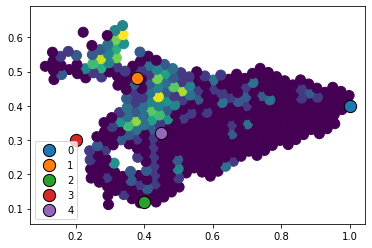

In [649]:
#landmarks_x = np.array([1.0,0.3,0.23,0.12,0.4]).reshape(-1,1)
#landmarks_y = np.array([0.5,0.6,0.15,0.4,0.4]).reshape(-1,1)
landmarks_x = np.array([1.0,0.38,0.4,0.2,0.45]).reshape(-1,1)
landmarks_y = np.array([0.4,0.48,0.12,0.3,0.32]).reshape(-1,1)
plt.scatter(crd2[:,0],crd2[:,1],s= 100,c = train_y)
for ii in range(len(landmarks_x)):
    plt.scatter(landmarks_x[ii],landmarks_y[ii],
                s = 150,label = str(ii),
                edgecolor = "black")
plt.axis("equal")
plt.legend()
lmrk = np.hstack((landmarks_x,landmarks_y))

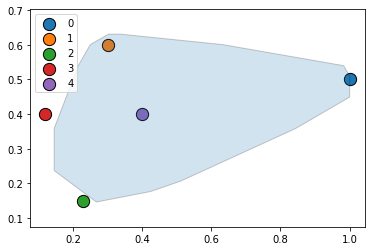

In [553]:
import alphashape
from descartes import PolygonPatch
alpha_shape = alphashape.alphashape([(crd2[i,0],crd2[i,1]) for i in range(len(crd2))], 0.)
fig, ax = plt.subplots()
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
for ii in range(len(landmarks_x)):
    plt.scatter(landmarks_x[ii],landmarks_y[ii],
                s = 150,label = str(ii),
                edgecolor = "black")
plt.axis("equal")
plt.legend()
plt.show()


In [554]:
import shapely as sh

xx = np.linspace(0,1,100)
X,Y = np.meshgrid(xx,xx)
X = X.flatten().reshape(-1,1)
Y = Y.flatten().reshape(-1,1)
new_crd = list()
for ii in range(len(X)):
    point = (X[ii],Y[ii])
    if alpha_shape.contains(sh.geometry.Point(point)):
        new_crd.append(point)
        
new_crd = np.array(new_crd)

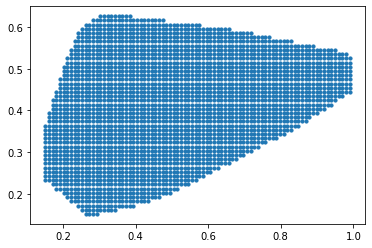

In [555]:
plt.scatter(new_crd[:,0],
            new_crd[:,1],s = 10)
plt.show()

In [650]:
lcrd = np.zeros((adata2.shape[0],lmrk.shape[0]))
#lcrd2 = np.zeros((new_crd.shape[0],lmrk.shape[0]))
for l in range(lmrk.shape[0]):
    for s1 in range(crd2.shape[0]):
        lcrd[s1,l] = ((crd2[s1,0] - lmrk[l,0])**2 +\
                      (crd2[s1,1] - lmrk[l,1])**2)**0.5
    
#    for s2 in range(new_crd.shape[0]):
#        lcrd2[s2,l] = ((new_crd[s2,0] - lmrk[l,0])**2 +\
#                       (new_crd[s2,1] - lmrk[l,1])**2)**0.5

In [643]:
train_x = t.tensor(lcrd.astype(np.float32))

In [651]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 2000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = t.optim.Adam(model.parameters(),
                         lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if (i+1) % 200 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 200/2000 - Loss: 0.744   lengthscale: 0.088   noise: 0.204
Iter 400/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 600/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 800/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 1000/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 1200/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 1400/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 1600/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 1800/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178
Iter 2000/2000 - Loss: 0.740   lengthscale: 0.071   noise: 0.178


In [652]:
test_x = t.tensor(lcrd2.astype(np.float32))

In [653]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with t.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

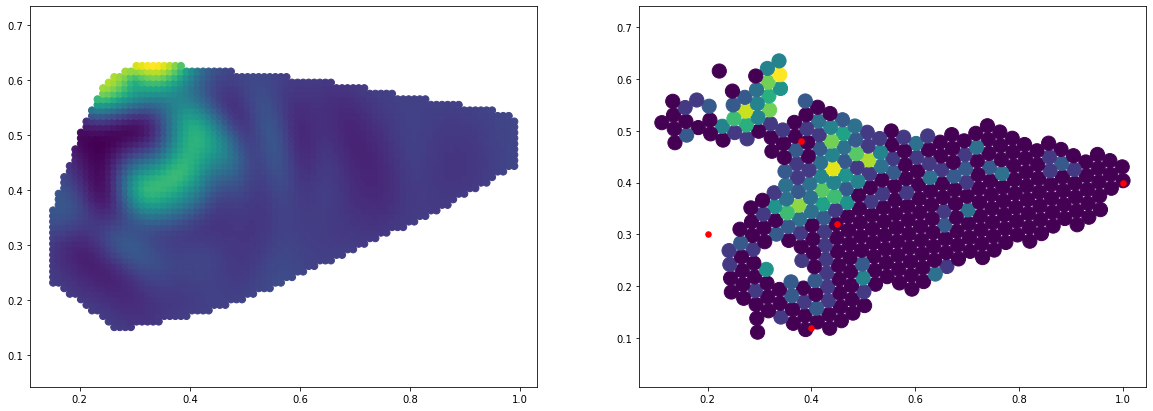

In [654]:
plt.figure(figsize = (20,7))

plt.subplot(121)

plt.scatter(new_crd[:,0],
            new_crd[:,1],
            s= 50,
            c = observed_pred.mean.numpy(),
           )

#plt.scatter(lmrk[:,0],
#            lmrk[:,1],
#            s = 25,
#            c  ="red")

plt.axis("equal")

plt.subplot(122)

plt.scatter(crd2[:,0],
            crd2[:,1],
            s= 200,
            c = train_y)

plt.scatter(landmarks_x,
            landmarks_y,
            s = 30,
            c  ="red",
           )

plt.axis("equal")
plt.show()